<a href="https://colab.research.google.com/github/dlmf15/kmeans_EFE_videos/blob/main/TFM_rmf_kmeans_202109.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
df = pd.read_csv('/content/efe_videos_clean.csv', delimiter=';')

In [ ]:
df.head()

,Cliente_c,Nº de accesos,Producto PAC,Tipo de abono,Fecha de la descarga,Video bruto/editado,precio,IPTC,Contador de consumos
0,271,0.0,EFE VÍDEO,Abono Mensual Abierto,14/6/18,Bruto,20,Política,1
1,271,0.0,EFE VÍDEO,Abono Mensual Abierto,14/6/18,Editado con locución,30,Política,1
2,271,0.0,EFE VÍDEO,Abono Mensual Abierto,14/6/18,Bruto,20,Justicia e interior,1
3,271,0.0,EFE VÍDEO,Abono Mensual Abierto,14/6/18,Bruto,20,Deporte,1
4,271,0.0,EFE VÍDEO,Abono Mensual Abierto,14/6/18,Bruto,20,Deporte,1


In [ ]:
df.tail()

,Cliente_c,Nº de accesos,Producto PAC,Tipo de abono,Fecha de la descarga,Video bruto/editado,precio,IPTC,Contador de consumos
18795,932955,1.2,EFE VÍDEO,Abono Mensual Cerrado,23/7/18,Bruto,20,Partidos,1
18796,932955,1.2,EFE VÍDEO,Abono Mensual Cerrado,23/7/18,Bruto,20,Partidos,1
18797,932955,1.2,EFE VÍDEO,Abono Mensual Cerrado,23/7/18,Bruto,20,Partidos,1
18798,932955,1.2,EFE VÍDEO,Abono Mensual Cerrado,23/7/18,Bruto,20,Partidos,1
18799,932955,1.2,EFE VÍDEO,Abono Mensual Cerrado,23/7/18,Bruto,20,Partidos,1


In [ ]:
df['Fecha de la descarga'] = pd.to_datetime(df['Fecha de la descarga'], format='%d/%m/%y')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18800 entries, 0 to 18799
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Cliente_c             18800 non-null  int64         
 1   Nº de accesos         18800 non-null  float64       
 2   Producto PAC          18800 non-null  object        
 3   Tipo de abono         18800 non-null  object        
 4   Fecha de la descarga  18800 non-null  datetime64[ns]
 5   Video bruto/editado   18800 non-null  object        
 6   precio                18800 non-null  int64         
 7   IPTC                  18800 non-null  object        
 8   Contador de consumos  18800 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 1.3+ MB


In [ ]:
df_M = df.groupby("Cliente_c")['precio'].agg(sum).reset_index()
df_M

,Cliente_c,precio
0,271,3620
1,323,12030
2,375,840
3,459,6775
4,638,2885
...,...,...
165,932528,2470
166,932636,9025
167,932750,120
168,932803,900


In [ ]:
NOW = df['Fecha de la descarga'].max() + timedelta(days=1)
df_R = df.groupby('Cliente_c').agg({'Fecha de la descarga': lambda x: (NOW-x.max()).days}).reset_index()
df_R

,Cliente_c,Fecha de la descarga
0,271,1
1,323,1
2,375,1
3,459,1
4,638,1
...,...,...
165,932528,1
166,932636,18
167,932750,34
168,932803,26


In [ ]:
df_F = df.groupby('Cliente_c')['Contador de consumos'].count().reset_index()
df_F

,Cliente_c,Contador de consumos
0,271,158
1,323,559
2,375,30
3,459,319
4,638,136
...,...,...
165,932528,104
166,932636,430
167,932750,4
168,932803,41


In [ ]:
rfm = pd.merge(df_R, df_F,on='Cliente_c')
rfm = pd.merge(rfm, df_M, on='Cliente_c' )
rfm = rfm.rename(columns={'Fecha de la descarga':'R', 'Cliente_c':'ID', 'precio':'M', 'Contador de consumos':'F'})
rfm

,ID,R,F,M
0,271,1,158,3620
1,323,1,559,12030
2,375,1,30,840
3,459,1,319,6775
4,638,1,136,2885
...,...,...,...,...
165,932528,1,104,2470
166,932636,18,430,9025
167,932750,34,4,120
168,932803,26,41,900


In [ ]:
quintiles = rfm[['R', 'F', 'M']].quantile([.2, .4, .6, .8, 1]).to_dict()
quintiles

{'F': {0.2: 7.0,
  0.4: 24.60000000000001,
  0.6: 89.59999999999997,
  0.8: 192.40000000000003,
  1.0: 853.0},
 'M': {0.2: 169.00000000000003,
  0.4: 592.0000000000002,
  0.6: 2242.999999999998,
  0.8: 4671.000000000001,
  1.0: 19220.0},
 'R': {0.2: 1.0, 0.4: 1.0, 0.6: 5.0, 0.8: 12.200000000000017, 1.0: 38.0}}

In [ ]:
def r_score(x):
    if x <= quintiles['R'][.2]:
        return 5
    elif x <= quintiles['R'][.4]:
        return 4
    elif x <= quintiles['R'][.6]:
        return 3
    elif x <= quintiles['R'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

In [ ]:
rfm_scale = rfm[['ID']]

In [ ]:
rfm['r'] = rfm['R'].apply(lambda x: r_score(x))
rfm['f'] = rfm['F'].apply(lambda x: fm_score(x, 'F'))
rfm['m'] = rfm['M'].apply(lambda x: fm_score(x, 'M'))
rfm['RFM_Score'] = rfm['r'].map(str) + rfm['f'].map(str) + rfm['m'].map(str)
rfm.head()

,ID,R,F,M,r,f,m,RFM_Score
0,271,1,158,3620,5,4,4,544
1,323,1,559,12030,5,5,5,555
2,375,1,30,840,5,3,3,533
3,459,1,319,6775,5,5,5,555
4,638,1,136,2885,5,4,4,544


In [ ]:
clus = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 300)
clus.fit(rfm[['R','F','M']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
pd.Series(clus.labels_).value_counts()

0    119
2     43
1      8
dtype: int64

In [ ]:
clus.cluster_centers_

array([[9.94117647e+00, 3.57058824e+01, 8.46344538e+02],
       [1.00000000e+00, 5.56000000e+02, 1.30375000e+04],
       [2.60465116e+00, 2.34953488e+02, 5.52604651e+03]])

In [ ]:
pd.DataFrame(clus.cluster_centers_)

,0,1,2
0,9.941176,35.705882,846.344538
1,1.000000,556.000000,13037.500000
2,2.604651,234.953488,5526.046512


In [ ]:
rfm['K_Cluster'] = clus.labels_
rfm.head()

,ID,R,F,M,r,f,m,RFM_Score,K_Cluster
0,271,1,158,3620,5,4,4,544,2
1,323,1,559,12030,5,5,5,555,1
2,375,1,30,840,5,3,3,533,0
3,459,1,319,6775,5,5,5,555,2
4,638,1,136,2885,5,4,4,544,0


In [ ]:
rfm.tail()

,ID,R,F,M,r,f,m,RFM_Score,K_Cluster
165,932528,1,104,2470,5,4,4,544,0
166,932636,18,430,9025,1,5,5,155,2
167,932750,34,4,120,1,1,1,111,0
168,932803,26,41,900,1,3,3,133,0
169,932955,1,67,1365,5,3,3,533,0


In [ ]:
rfm.to_excel('rfm_kmeans3.xlsx', index=False)

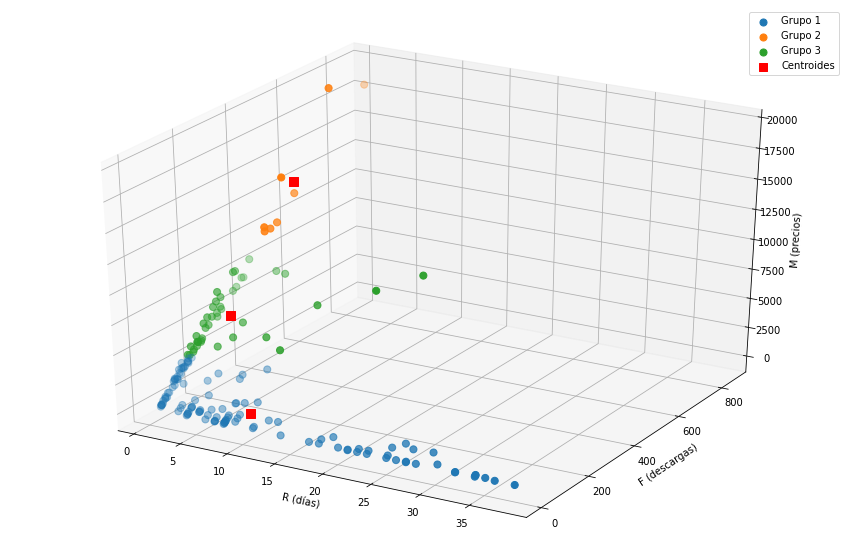

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i in range(0,3):
    dx.scatter(rfm[rfm.K_Cluster == i]['R'], 
               rfm[rfm.K_Cluster == i]['F'], 
               rfm[rfm.K_Cluster == i]['M'], 
               c = colors[i], 
               label = 'Grupo ' + str(i+1), 
               s=50)
dx.scatter(clus.cluster_centers_[:,0], clus.cluster_centers_[:,1],clus.cluster_centers_[:,2],s=80,marker='s', c='r', alpha=1, label='Centroides')

#dx.set_title('Clusters of clients')
dx.set_xlabel('R (días)')
dx.set_ylabel('F (descargas)')
dx.set_zlabel('M (precios)')
dx.legend()

fig.savefig('/content/3d_plot_cluster3.png')

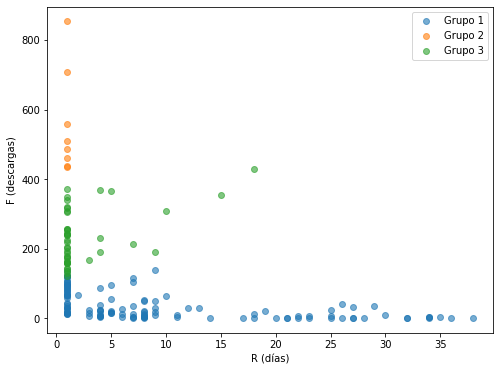

In [ ]:
fig = plt.figure(figsize=(8,6))
c1 = rfm[rfm.K_Cluster == 0]
c2 = rfm[rfm.K_Cluster == 1]
c3 = rfm[rfm.K_Cluster == 2]


plt.scatter(c1.R, c1.F, c = '#1f77b4', label = 'Grupo 1', alpha=0.6)
plt.scatter(c2.R, c2.F, c = '#ff7f0e', label = 'Grupo 2', alpha=0.6)
plt.scatter(c3.R, c3.F, c = '#2ca02c', label = 'Grupo 3', alpha=0.6)

#plt.title('Clusters of clients')
plt.xlabel('R (días)')
plt.ylabel('F (descargas)')
plt.legend()
fig.savefig('FR_3.png')

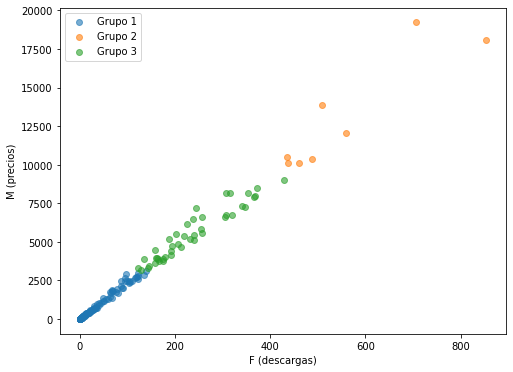

In [ ]:
fig = plt.figure(figsize=(8,6))
c1 = rfm[rfm.K_Cluster == 0]
c2 = rfm[rfm.K_Cluster == 1]
c3 = rfm[rfm.K_Cluster == 2]


plt.scatter(c1.F, c1.M, c = '#1f77b4', label = 'Grupo 1', alpha=0.6)
plt.scatter(c2.F, c2.M, c = '#ff7f0e', label = 'Grupo 2', alpha=0.6)
plt.scatter(c3.F, c3.M, c = '#2ca02c', label = 'Grupo 3', alpha=0.6)


#plt.title('Clusters of clients')
plt.xlabel('F (descargas)')
plt.ylabel('M (precios)')
plt.legend()
fig.savefig('MF_3.png')

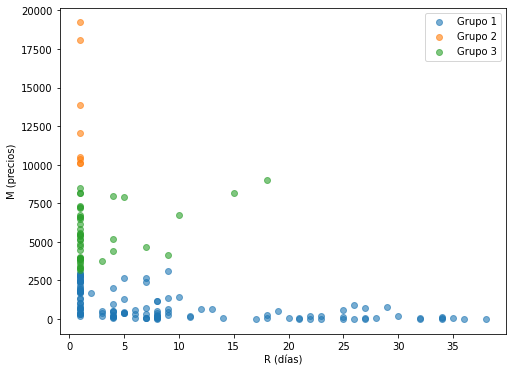

In [ ]:
fig = plt.figure(figsize=(8,6))
c1 = rfm[rfm.K_Cluster == 0]
c2 = rfm[rfm.K_Cluster == 1]
c3 = rfm[rfm.K_Cluster == 2]

plt.scatter(c1.R, c1.M, c = '#1f77b4', label = 'Grupo 1',alpha=0.6)
plt.scatter(c2.R, c2.M, c = '#ff7f0e', label = 'Grupo 2', alpha=0.6)
plt.scatter(c3.R, c3.M, c = '#2ca02c', label = 'Grupo 3', alpha=0.6)

#plt.title('Clusters of clients')
plt.xlabel('R (días)')
plt.ylabel('M (precios)')
plt.legend()

fig.savefig('MR_3.png')

In [ ]:
df_3 = df

In [ ]:
df_3['K_cluster'] = df_3['Cliente_c'].map(rfm.set_index('ID')['K_Cluster'])

df_3

,Cliente_c,Nº de accesos,Producto PAC,Tipo de abono,Fecha de la descarga,Video bruto/editado,precio,IPTC,Contador de consumos,K_cluster
0,271,0.0,EFE VÍDEO,Abono Mensual Abierto,2018-06-14,Bruto,20,Política,1,2
1,271,0.0,EFE VÍDEO,Abono Mensual Abierto,2018-06-14,Editado con locución,30,Política,1,2
2,271,0.0,EFE VÍDEO,Abono Mensual Abierto,2018-06-14,Bruto,20,Justicia e interior,1,2
3,271,0.0,EFE VÍDEO,Abono Mensual Abierto,2018-06-14,Bruto,20,Deporte,1,2
4,271,0.0,EFE VÍDEO,Abono Mensual Abierto,2018-06-14,Bruto,20,Deporte,1,2
...,...,...,...,...,...,...,...,...,...,...
18795,932955,1.2,EFE VÍDEO,Abono Mensual Cerrado,2018-07-23,Bruto,20,Partidos,1,0
18796,932955,1.2,EFE VÍDEO,Abono Mensual Cerrado,2018-07-23,Bruto,20,Partidos,1,0
18797,932955,1.2,EFE VÍDEO,Abono Mensual Cerrado,2018-07-23,Bruto,20,Partidos,1,0
18798,932955,1.2,EFE VÍDEO,Abono Mensual Cerrado,2018-07-23,Bruto,20,Partidos,1,0


In [ ]:
iptc = df_3.groupby(['K_cluster','IPTC'], as_index=False)['Contador de consumos'].count()

In [ ]:
iptc.to_excel('iptc_3.xlsx', index=False)

In [ ]:
fecha_3 = df_3.groupby(['K_cluster','Fecha de la descarga'], as_index=False)['Contador de consumos'].count()
fecha_3

,K_cluster,Fecha de la descarga,Contador de consumos
0,0,2018-06-14,195
1,0,2018-06-15,120
2,0,2018-06-16,55
3,0,2018-06-17,72
4,0,2018-06-18,157
...,...,...,...
115,2,2018-07-19,172
116,2,2018-07-20,202
117,2,2018-07-21,71
118,2,2018-07-22,91


In [ ]:
fecha_3 = fecha_3.groupby(['Fecha de la descarga', 'K_cluster'])['Contador de consumos'].sum()
fecha_3 = fecha_3.unstack(level='K_cluster')
fecha_3

K_cluster,0,1,2
Fecha de la descarga,,,
2018-06-14,195,123,441
2018-06-15,120,127,335
2018-06-16,55,54,151
2018-06-17,72,92,165
2018-06-18,157,163,503
2018-06-19,203,142,393
2018-06-20,132,113,405
2018-06-21,104,143,303
2018-06-22,101,141,310


In [ ]:
fecha_3.columns

Index(['Grupo 1', 'Grupo 2', 'Grupo 3'], dtype='object', name='K_cluster')

In [ ]:
fecha_3 = fecha_3.rename(columns={0: 'Grupo 1', 
                        1: 'Grupo 2', 
                        2: 'Grupo 3' 
                       })
fecha_3

K_cluster,Grupo 1,Grupo 2,Grupo 3
Fecha de la descarga,,,
2018-06-14,195,123,441
2018-06-15,120,127,335
2018-06-16,55,54,151
2018-06-17,72,92,165
2018-06-18,157,163,503
2018-06-19,203,142,393
2018-06-20,132,113,405
2018-06-21,104,143,303
2018-06-22,101,141,310


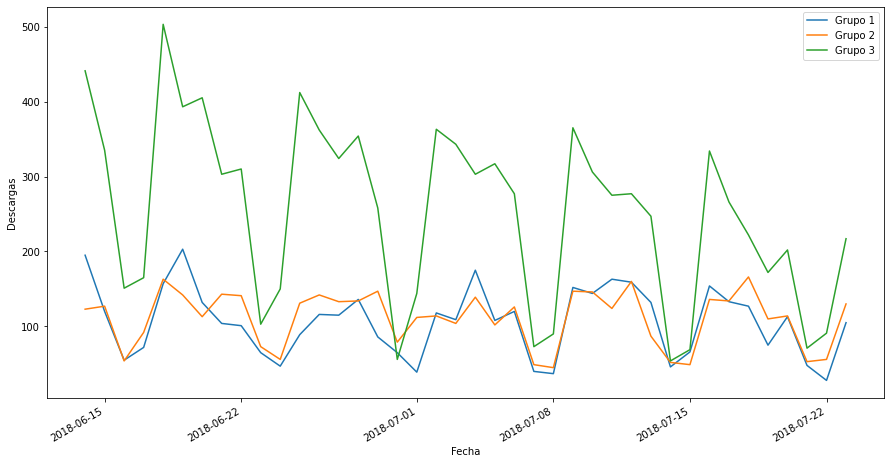

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
fig.autofmt_xdate()
plt.xlabel('Fecha')
plt.ylabel('Descargas')

#colors=['r', 'g','b', 'c', 'm' for x in fecha_5.columns]

plt.plot(fecha_3)
plt.legend(fecha_3.columns)
plt.show()
fig.savefig('fecha_kmeans3.png')

In [ ]:
count_3 = df_3.groupby(['K_cluster'], as_index=False)['Contador de consumos'].count()
count_3.index = ['Grupo 1', 'Grupo 2', 'Grupo 3']

In [ ]:
count_client_3 = df_3.groupby(['K_cluster', 'Cliente_c'], as_index=False)['Contador de consumos'].count()
count_client_3

,K_cluster,Cliente_c,Contador de consumos
0,0,375,30
1,0,638,136
2,0,814,6
3,0,1256,100
4,0,1312,80
...,...,...,...
165,2,931679,167
166,2,932029,340
167,2,932133,202
168,2,932310,305


In [ ]:
count_client_3.groupby('K_cluster', as_index=False)['Contador de consumos'].mean()

,K_cluster,Contador de consumos
0,0,35.705882
1,1,556.000000
2,2,234.953488


In [ ]:
count_3

,K_cluster,Contador de consumos
Grupo 1,0,4249
Grupo 2,1,4448
Grupo 3,2,10103


In [ ]:
sum_precios = df_3.groupby(['K_cluster', 'Cliente_c'], as_index=False)['precio'].sum()
sum_precios

,K_cluster,Cliente_c,precio
0,0,375,840
1,0,638,2885
2,0,814,120
3,0,1256,2450
4,0,1312,1720
...,...,...,...
165,2,931679,3780
166,2,932029,7315
167,2,932133,5540
168,2,932310,6590


In [ ]:
df_3.groupby(['K_cluster'], as_index=False)['precio'].sum()

,K_cluster,precio
0,0,100715
1,1,104300
2,2,237620


In [ ]:
sum_precios.groupby('K_cluster', as_index=False)['precio'].mean()


,K_cluster,precio
0,0,846.344538
1,1,13037.500000
2,2,5526.046512
